In [4]:
from qutip import *
import numpy as np
from scipy import constants
import datetime
import time
import gc
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize_scalar
import math
from scipy.optimize import curve_fit
from scipy.sparse.linalg import eigs

In [5]:
#constants
hbar = constants.hbar
amu = constants.m_p
pi = constants.pi
MHz = 10**6;

In [6]:
#basis {e,+,0,-}
N = 4
e = basis(N,0)
p = basis(N,1)
z = basis(N,2)
m = basis(N,3)

## Rest ion

In [7]:
def pope(Gamma,Omegasp,Omegasm,Omegap,Deltad,Deltap,deltab):

    pop_e = []

    tstart = time.time();

    #linbland operator/collapse operators
    c1 = np.sqrt(Gamma/3)*p*e.dag()
    c2 = np.sqrt(Gamma/3)*z*e.dag()
    c3 = np.sqrt(Gamma/3)*m*e.dag()

    c = [c1,c2,c3]
    #c_ops =[spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i])) for i in range(N-1)]

    #initial state
    rho0 = z*z.dag()

   

    #Hamiltonian for a rest ion
    H1 = -0.5*(Omegasm*e*p.dag() + Omegap*e*z.dag() + Omegasp*e*m.dag())
    H2 = -0.5*Omegasm*p*e.dag() + (Deltad + deltab)*p*p.dag()
    H3 = -0.5*Omegap*z*e.dag() + Deltap*z*z.dag()
    H4 = -0.5*Omegasp*m*e.dag() + (Deltad - deltab)*m*m.dag()

    H = H1 + H2 + H3 + H4

    #rho = mesolve(H,rho0,tlist,c_ops,[e*e.dag()],options=options)
    rho = steadystate(H,c)

    return expect(e*e.dag(),rho)

## Fictitious lasers

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [9]:
def steck(Gamma,Omegasp,Omegasm,Omegap,Deltad,Deltap,deltab, omega,eta):
    H1 = -0.5*(Omegasm*e*p.dag() + Omegap*e*z.dag() + Omegasp*e*m.dag())
    H2 = -0.5*Omegasm*p*e.dag() + (Deltad + deltab)*p*p.dag()
    H3 = -0.5*Omegap*z*e.dag() + Deltap*z*z.dag()
    H4 = -0.5*Omegasp*m*e.dag() + (Deltad - deltab)*m*m.dag()

    H0 = H1 + H2 + H3 + H4

    c1 = np.sqrt(Gamma/3)*p*e.dag()
    c2 = np.sqrt(Gamma/3)*z*e.dag()
    c3 = np.sqrt(Gamma/3)*m*e.dag()

    c = [c1,c2,c3]

    rho0 = steadystate(H0,c)

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    H_1 = -0.5*(eta*Omegasm*e*p.dag() -eta*Omegap*e*z.dag() + eta*Omegasp*e*m.dag())
    L_1 = -1j*(spre(H_1) - spost(H_1))

    #L_1 = np.array(L_1)
    L_1 = L_1.data_as('ndarray')

    H1 = H_1.dag()
    L1 = -1j*(spre(H1) - spost(H1))

    #L1 = np.array(L1)
    L1 = L1.data_as('ndarray')
    



    S3 = -np.matmul(inv(L0-3j*omega*np.eye(N**2)),L1)
    S2 = -np.matmul(inv(L0-2j*omega*np.eye(N**2)+ np.matmul(L_1,S3)),L1)
    #S2 = -np.matmul(inv(L0-2j*Deltap*np.eye(N**2)),L1)
    S1 = -np.matmul(inv(L0-1j*omega*np.eye(N**2) + np.matmul(L_1,S2)),L1) 
    #S1 = -np.matmul(inv(L0-1j*Deltap*np.eye(N**2)),L1) 

    T_3 = -np.matmul(inv(L0+3j*omega*np.eye(N**2)),L_1)
    T_2 = -np.matmul(inv(L0+2j*omega*np.eye(N**2)+ np.matmul(L1,T_3)),L_1)
    #T_2 = -np.matmul(inv(L0+2j*Deltap*np.eye(N**2)),L_1)
    T_1 = -np.matmul(inv(L0+1j*omega*np.eye(N**2)+ np.matmul(L1,T_2)),L_1)
    #T_1 = -np.matmul(inv(L0+1j*Deltap*np.eye(N**2)),L_1)
    
    L = np.matmul(L_1,S1) + L0 +np.matmul(L1,T_1)
    
    eigenvalues, eigenvectors = LA.eig(L)

    idx = find_nearest(eigenvalues, 0+0j)
    rhoss = eigenvectors[:,idx]

    rhos = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos[j,i] = rhoss[j+i*N]

    rho = Qobj(rhos)
    if rho.tr() != 0:
        rho = rho/rho.tr()

    rho_ = operator_to_vector(rho)
    #rho_ = np.array(rho_)
    rho_ = rho_.data_as('ndarray')

    rho1 = np.matmul(S1,rho_)
    #rho2 = np.matmul(S2,rho_)
    #rho3 = np.matmul(S3,rho_)

    rho_1 = np.matmul(T_1,rho_)
    #rho_2 = np.matmul(T_2,rho_)
    #rho_3 = np.matmul(T_3,rho_)

    rhos1 = np.zeros((N,N),dtype='complex64')
    #rhos2 = np.zeros((N,N),dtype='complex64')
    #rhos3 = np.zeros((N,N),dtype='complex64')
    rhos_1 = np.zeros((N,N),dtype='complex64')
    #rhos_2 = np.zeros((N,N),dtype='complex64')
    #rhos_3 = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos1[j,i] = rho1[j+i*N]
            #rhos2[j,i] = rho2[j+i*N]
            #rhos3[j,i] = rho3[j+i*N]
            rhos_1[j,i] = rho_1[j+i*N]
            #rhos_2[j,i] = rho_2[j+i*N]
            #rhos_3[j,i] = rho_3[j+i*N]
            
    Rho1 = Qobj(rhos1)
    #Rho2 = Qobj(rhos2)
    #Rho3 = Qobj(rhos3)
    Rho_1 = Qobj(rhos_1)
    #Rho_2 = Qobj(rhos_2)
    #Rho_3 = Qobj(rhos_3)

    return (-1j*2*np.pi*(eta*Omegasm/2*expect(p*e.dag(),Rho_1)  
                            -eta*Omegap/2*expect(z*e.dag(),Rho_1)   
                            +eta*Omegasp/2*expect(m*e.dag(),Rho_1) 
                            -eta*Omegasm/2*(expect(e*p.dag(),Rho1) ) 
                            +eta*Omegap/2*(expect(e*z.dag(),Rho1)  ))
                            -eta*Omegasp/2*(expect(e*m.dag(),Rho1) ) )



## Fluctuation spectrum

In [10]:
def S_(Gamma, Deltad, deltab, Deltap, Omegasp, Omegasm, Omegap,omega, eta):
    H1 = -pi*(Omegasm*e*p.dag() + Omegap*e*z.dag() + Omegasp*e*m.dag())
    H2 = -pi*Omegasm*p*e.dag() + 2*pi*(Deltad + deltab)*p*p.dag()
    H3 = -pi*Omegap*z*e.dag() + 2*pi*Deltap*z*z.dag()
    H4 = -pi*Omegasp*m*e.dag() + 2*pi*(Deltad - deltab)*m*m.dag()

    H0 = H1 + H2 + H3 + H4

    c1 = np.sqrt(2*pi*Gamma/3)*p*e.dag()
    c2 = np.sqrt(2*pi*Gamma/3)*z*e.dag()
    c3 = np.sqrt(2*pi*Gamma/3)*m*e.dag()

    c = [c1,c2,c3]
    rho = steadystate(H0,c) #!
    
    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    V1 = -pi*(eta*Omegasm*e*p.dag() -eta*Omegap*e*z.dag() + eta*Omegasp*e*m.dag())
    V1 = V1 + V1.dag()
    V1rho = V1*rho

    V1rho = operator_to_vector(V1rho)
    #V1rho = np.array(V1rho)
    V1rho = V1rho.data_as('ndarray')

    eye = np.eye(N**2)
    inve = -inv((L0+1j*2*pi*omega*eye))

    s = inve@V1rho

    S = np.zeros((N,N),dtype=np.complex_)
    for i in range(N):
        for j in range(N):
            S[j,i] = s[N*i+j][0]
            
    #V1 = np.array(V1)
    V1 =V1.data_as('ndarray')
    S = np.matmul(V1,S)

    return np.matrix.trace(S)

In [11]:
Gamma = 20
Deltad = 60
Omegasp = 16.5
Omegasm = Omegasp
Omegap = Omegasp
deltab = 10
Deltap = Deltad + deltab #metavlito
omega = 2 #trap frequency
eta = 0.01

In [12]:
ratios = np.array([0.01,0.025,0.05,0.075,0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2])

In [13]:
wabs = np.zeros(len(ratios))
wfic = np.zeros(len(ratios),dtype='complex')
w = np.zeros(len(ratios),dtype='complex')

for i in range(len(ratios)):
    wabs[i] = eta**2*2*np.pi*Gamma*(pope(Gamma,Omegasp,Omegasm,ratios[i]*Omegasp,Deltad,Deltap + omega,deltab)
                                    -pope(Gamma,Omegasp,Omegasm,ratios[i]*Omegasp,Deltad,Deltap - omega,deltab))
    
    wfic[i] = (steck(Gamma,Omegasp,Omegasm,ratios[i]*Omegasp,Deltad,Deltap,deltab,omega,eta) 
               - steck(Gamma,Omegasp,Omegasm,ratios[i]*Omegasp,Deltad,Deltap,deltab,-omega,eta))

    w[i] = 2*(S_(Gamma, Deltad, deltab, Deltap, Omegasp, Omegasm, ratios[i]*Omegasp,omega, eta) 
              - S_(Gamma, Deltad, deltab, Deltap, Omegasp, Omegasm, ratios[i]*Omegasp,-omega, eta))

C:\Users\kfouka\AppData\Local\Temp\ipykernel_13188\2252187858.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_13188\2252187858.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]


In [14]:
wabs

array([ 1.68462314e-07,  1.04745023e-06,  4.11358037e-06,  8.98082645e-06,
        1.53207132e-05,  6.23044031e-05,  8.48832052e-05,  4.69344576e-05,
       -2.75440732e-06, -3.98262074e-05, -5.61795249e-05, -5.49204077e-05,
       -4.47449880e-05])

In [15]:
wfic

array([2.24884629e-07+6.28805454e-11j, 1.40640627e-06+3.93259719e-10j,
       5.63819688e-06+1.57675255e-09j, 1.27333851e-05+3.56171439e-09j,
       2.27563253e-05+6.36695190e-09j, 1.51848397e-04+4.26325675e-08j,
       8.00039576e-04+2.27506067e-07j, 3.43843462e-03+9.98440373e-07j,
       1.64596432e-02+4.89412561e-06j, 4.66779193e-03+1.40077520e-06j,
       1.20868215e-03+3.35010043e-07j, 4.66552066e-04+8.05933549e-08j,
       2.16658105e-04+7.97589974e-08j])

In [16]:
wfic.real/wabs

array([ 1.33492544e+00,  1.34269508e+00,  1.37063005e+00,  1.41784113e+00,
        1.48533068e+00,  2.43720170e+00,  9.42518104e+00,  7.32603465e+01,
       -5.97574772e+03, -1.17204028e+02, -2.15146382e+01, -8.49505831e+00,
       -4.84206420e+00])

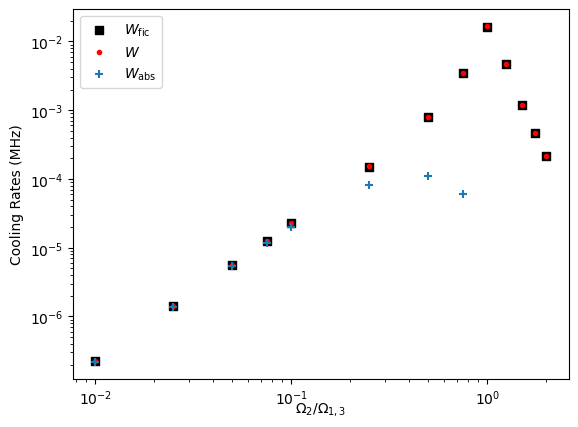

In [17]:
plt.figure()

plt.scatter(ratios,wfic.real,marker='s',color='black',label=r'$W_{\text{fic}}$')
plt.scatter(ratios,w.real,marker='.',label=r'$W$',color='red')
plt.scatter(ratios,1.3*wabs,marker='+',label=r'$W_{\text{abs}}$')
#ax4.scatter([1,2,3,4,5,6],wexp,marker='+',label='$W_{exp}$',color=['black','royalblue','lightblue'])
plt.yscale('log')
plt.xscale('log')

plt.ylabel('Cooling Rates (MHz)')
plt.xlabel('$\Omega_2/\Omega_{1,3}$',labelpad=-5)
plt.legend()
plt.show()

In [18]:
ratios[:-2]

array([0.01 , 0.025, 0.05 , 0.075, 0.1  , 0.25 , 0.5  , 0.75 , 1.   ,
       1.25 , 1.5  ])

In [19]:
ratios

array([0.01 , 0.025, 0.05 , 0.075, 0.1  , 0.25 , 0.5  , 0.75 , 1.   ,
       1.25 , 1.5  , 1.75 , 2.   ])

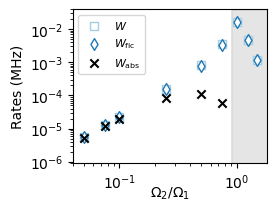

In [20]:
plt.figure(figsize=(2.5,2))
plt.fill_between(np.linspace(0.9,2.25,1000),y1=9e-7,y2=4e-2, color='grey', alpha=0.2)
plt.scatter(ratios[:-2],w.real[:-2],marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(ratios[:-2],wfic.real[:-2],marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(ratios[:-2],1.3*wabs[:-2],marker='x',label=r'$W_{\text{abs}}$',color='black',s=plt.rcParams['lines.markersize'] ** 2)
#plt.scatter(Ratios[:-2],wexp[:-2],marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)


#ax4.scatter([1,2,3,4,5,6],wexp,marker='+',label='$W_{exp}$',color=['black','royalblue','lightblue'])
plt.yscale('log')
plt.xscale('log')
plt.xlim(4e-2,1.8)
plt.ylim(9e-7,4e-2)
plt.ylabel('Rates (MHz)')
plt.xlabel('$\Omega_2/\Omega_{1}$',labelpad=-5)

plt.legend(prop={'size': 8})
#plt.savefig("eit_Omega1_2.pdf",bbox_inches = "tight")
plt.show()

## Cooling

In [22]:
t = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_24.75_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_24.75_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [23]:
t1 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_20.625_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n1 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_20.625_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [24]:
t2 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_16.5_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n2 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_16.5_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [25]:
t3 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_12.375_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n3 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_12.375_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [26]:
t4 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_8.25_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n4 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_8.25_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [27]:
t5 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_4.125_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n5 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_4.125_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [28]:
t6 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_1.6500000000000001_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n6 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_1.6500000000000001_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [29]:
t7 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_1.2375_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n7 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_1.2375_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [103]:
t8 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_0.8250000000000001_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 0]
n8 = np.loadtxt(""+str(path_name)+"cooling_double_EIT_Omegasp_16.5_Omegap_0.8250000000000001_Deltad_60_Deltap_70_Gamma_20_eta_0.01.txt")[:, 1]

In [30]:
4.125/16.5

0.25

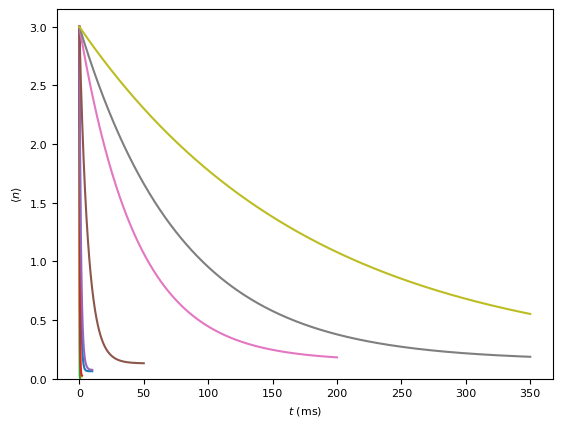

In [105]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t*1e-3,n)
plt.plot(t1*1e-3,n1)
plt.plot(t2*1e-3,n2)
plt.plot(t3*1e-3,n3)
plt.plot(t4*1e-3,n4)
plt.plot(t5*1e-3,n5)
plt.plot(t6*1e-3,n6)
plt.plot(t7*1e-3,n7)
plt.plot(t8*1e-3,n8)

plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)


#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [32]:
def func(t,a,b,c):
    return a*np.exp(-b*t) + c*(1-np.exp(-b*t))

In [33]:
p0 = (3, .001,.001)
popt, pcov = curve_fit(func,t,n,p0)
popt

array([3.00426167e+00, 1.20323581e-03, 6.38395749e-02])

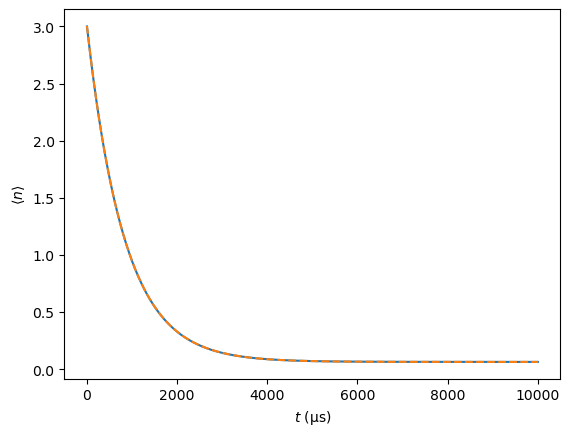

In [34]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t,n)
plt.plot(t,func(t,*popt),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [35]:
p0 = (3, .001,.001)
popt1, pcov = curve_fit(func,t1,n1,p0)
popt1

array([3.02036774, 0.00459918, 0.0182797 ])

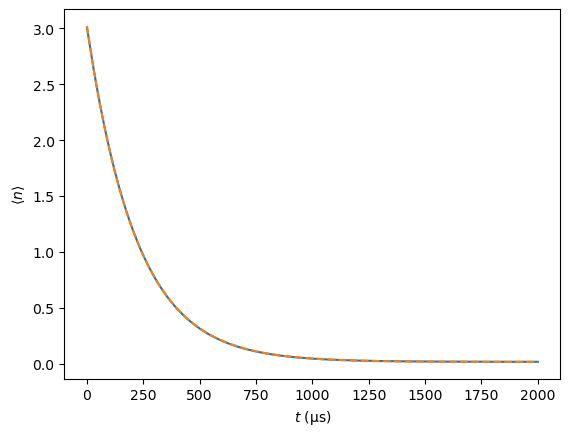

In [36]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t1,n1)
plt.plot(t1,func(t1,*popt1),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [37]:
p0 = (3, .001,.001)
popt2, pcov = curve_fit(func,t2[:400],n2[:400],p0)
popt2

array([ 3.07871669,  0.01515491, -0.03333303])

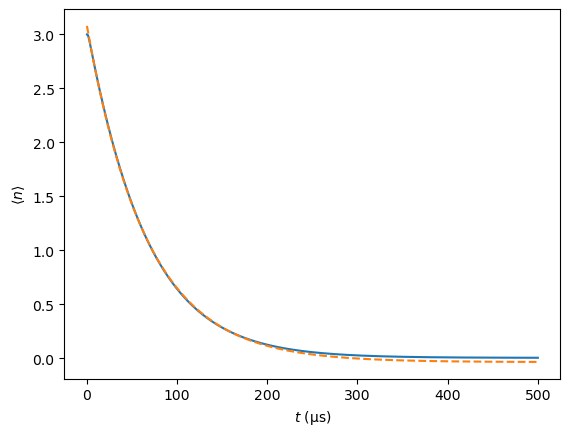

In [38]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t2,n2)
plt.plot(t2,func(t2,*popt2),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [39]:
p0 = (3, .001,.001)
popt3, pcov = curve_fit(func,t3,n3,p0)
popt3

array([3.0167819 , 0.00338412, 0.02412985])

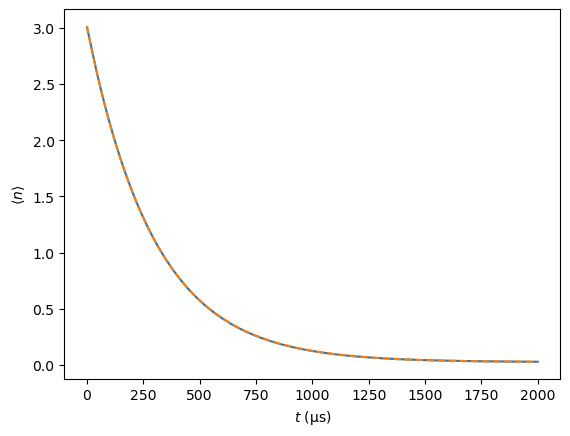

In [40]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t3,n3)
plt.plot(t3,func(t3,*popt3),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [41]:
p0 = (3, .001,.001)
popt4, pcov = curve_fit(func,t4,n4,p0)
popt4

array([3.00434700e+00, 7.95613881e-04, 7.41369341e-02])

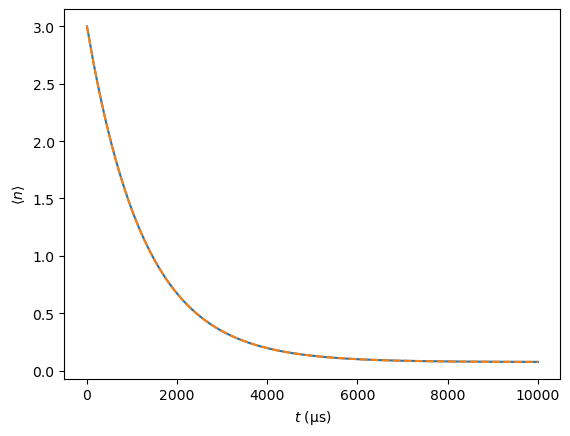

In [42]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t4,n4)
plt.plot(t4,func(t4,*popt4),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [43]:
p0 = (3, .001,.001)
popt5, pcov = curve_fit(func,t5,n5,p0)
popt5

array([3.00092761e+00, 1.51419317e-04, 1.30249735e-01])

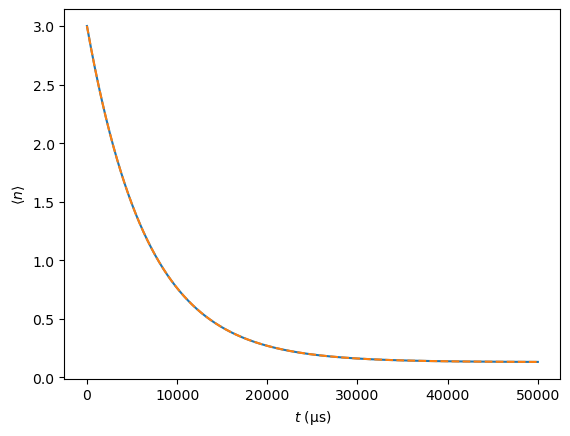

In [44]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t5,n5)
plt.plot(t5,func(t5,*popt5),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [45]:
p0 = (3, .001,.001)
popt6, pcov = curve_fit(func,t6,n6,p0)
popt6

array([3.00006578e+00, 2.27016771e-05, 1.51505758e-01])

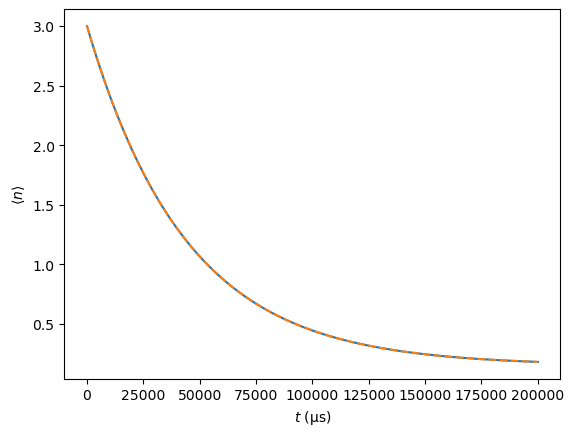

In [46]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t6,n6)
plt.plot(t6,func(t6,*popt6),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [47]:
p0 = (3, .001,.001)
popt7, pcov = curve_fit(func,t7,n7,p0)
popt7

array([3.00000607e+00, 1.27034118e-05, 1.53429569e-01])

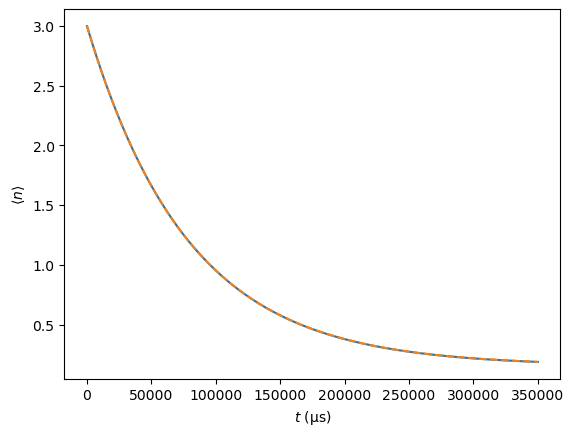

In [48]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t7,n7)
plt.plot(t7,func(t7,*popt7),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [107]:
p0 = (3, .001,.001)
popt8, pcov = curve_fit(func,t8,n8,p0)
popt8

array([2.99981371e+00, 5.62312273e-06, 1.54415684e-01])

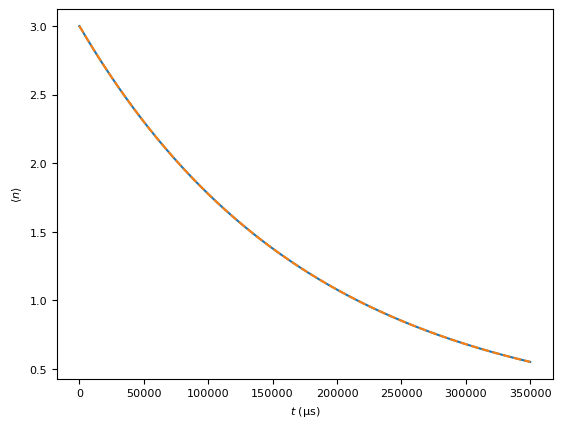

In [113]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t8,n8)
plt.plot(t8,func(t8,*popt8),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [115]:
Ratios = [0.05,0.075,0.1,0.25,0.5,0.75,1,1.25,1.5]

In [117]:
wexp = [popt8[1],popt7[1],popt6[1],popt5[1],popt4[1],popt3[1],popt2[1],popt1[1],popt[1]]

In [119]:
w

array([2.24865358e-07+5.61847202e-07j, 1.40628844e-06+3.51254708e-06j,
       5.63776248e-06+1.40645274e-05j, 1.27325467e-05+3.16991443e-05j,
       2.27551884e-05+5.64890289e-05j, 1.51871067e-04+3.63594925e-04j,
       8.00917082e-04+1.63336142e-03j, 3.45543851e-03+4.53423502e-03j,
       1.68878508e-02+1.47310324e-04j, 4.70672000e-03-1.01501760e-02j,
       1.21104385e-03-6.72197572e-03j, 4.62631910e-04-4.91405383e-03j,
       2.14666015e-04-3.84269804e-03j])

In [121]:
ratios

array([0.01 , 0.025, 0.05 , 0.075, 0.1  , 0.25 , 0.5  , 0.75 , 1.   ,
       1.25 , 1.5  , 1.75 , 2.   ])

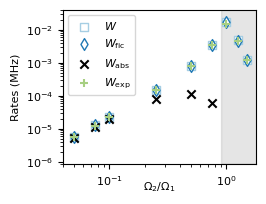

In [123]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(2.5,2))
plt.fill_between(np.linspace(0.9,2.25,1000),y1=9e-7,y2=4e-2, color='grey', alpha=0.2)
plt.scatter(ratios[:-2],w.real[:-2],marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(ratios[:-2],wfic.real[:-2],marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(ratios[:-2],1.3*wabs[:-2],marker='x',label=r'$W_{\text{abs}}$',color='black',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(Ratios,wexp,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)


#ax4.scatter([1,2,3,4,5,6],wexp,marker='+',label='$W_{exp}$',color=['black','royalblue','lightblue'])
plt.yscale('log')
plt.xscale('log')
plt.xlim(4e-2,1.8)
plt.ylim(9e-7,4e-2)
plt.ylabel('Rates (MHz)')
plt.xlabel('$\Omega_2/\Omega_{1}$',labelpad=-5)

plt.legend(prop={'size': 8})
plt.savefig("double_eit_Omega1_2.pdf",bbox_inches = "tight")
plt.show()